In [1]:
import dlib
import os
import shutil
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, c, h, w].
        Returns:
            a float tensor with shape [batch_size, c*h*w].
        """

        x = x.transpose(3, 2).contiguous()

        return x.view(x.size(0), -1)

class ONet(nn.Module):
    def __init__(self):
        super(ONet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 32, 3, 1)),
            ('prelu1', nn.PReLU(32)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(32, 64, 3, 1)),
            ('prelu2', nn.PReLU(64)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(64, 64, 3, 1)),
            ('prelu3', nn.PReLU(64)),
            ('pool3', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv4', nn.Conv2d(64, 128, 2, 1)),
            ('prelu4', nn.PReLU(128)),

            ('flatten', Flatten()),
            ('conv5', nn.Linear(1152, 256)),
            ('drop5', nn.Dropout(0.25)),
            ('prelu5', nn.PReLU(256)),
        ]))

        # Output layer with 136 features
        self.output_layer = nn.Linear(256, 136)

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            landmarks: a float tensor with shape [batch_size, 136].
        """
        x = self.features(x)
        landmarks = self.output_layer(x)
        return landmarks

def visualize_face_with_original_landmarks(image, landmarks_original):
    image = cv2.imread(image)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    for landmark in landmarks_original:
        x, y = landmark
        if x != -1 and y != -1:
            plt.scatter(x, y, color='red', s=5)
    
    plt.axis('off')
    plt.show()

def load_landmarks(file_path):
    with open(file_path, 'r') as f:
        landmarks = []
        for line in f.readlines()[3:-1]:  # skip the first 3 and last lines
            x, y = map(float, line.split())
            landmarks.append([x, y])
        return np.array(landmarks)

In [108]:
def inference_on_image_torch(image, model, gt_landmarks):
    device = 'cuda'
    model.to(device)
    detector = dlib.get_frontal_face_detector()
    image = cv2.imread(image)
    
    # Convert normalized landmarks to original image coordinates
    def denormalize_landmarks(landmarks, face):
        face_width = face.right() - face.left()
        face_height = face.bottom() - face.top()
        denormalized_landmarks = []
        for x_norm, y_norm in landmarks:
            if x_norm == -1 and y_norm == -1:
                denormalized_landmarks.append([-1, -1])
            else:
                x_denorm = int((x_norm * face_width) + face.left())
                y_denorm = int((y_norm * face_height) + face.top())
                denormalized_landmarks.append([x_denorm, y_denorm])
        return denormalized_landmarks
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the grayscale image
    faces = detector(gray)
    
    if len(faces) == 0:
        return None
    
    # Initialize variables to store information about the best face
    best_face = None
    max_landmarks_inside = 0
    
    # Iterate over all detected faces to find the one with the most landmarks inside
    for face in faces:
        landmarks_inside_bbox = 0
        for landmark in gt_landmarks:
            x, y = landmark
            if face.left() <= x <= face.right() and face.top() <= y <= face.bottom():
                landmarks_inside_bbox += 1

        # Update the best face if the current face contains more landmarks
        if landmarks_inside_bbox > max_landmarks_inside:
            best_face = face
            max_landmarks_inside = landmarks_inside_bbox
    
    if best_face is None:
        return None
    
    # Extract the face region
    face_image = image[best_face.top():best_face.bottom(), best_face.left():best_face.right()]
    
    # Resize the face image to (48, 48)
    face_image_resized = cv2.resize(face_image, (48, 48))
    face_image_resized = cv2.cvtColor(face_image_resized, cv2.COLOR_BGR2RGB)
    face_image_resized = transforms.ToPILImage()(face_image_resized)
    face_tensor = transforms.ToTensor()(face_image_resized)
    face_tensor = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(face_tensor)
    face_tensor = torch.unsqueeze(face_tensor, 0).to(device)
    model.eval()
    with torch.no_grad():
        landmarks_normalized = model(face_tensor).cpu().numpy().reshape(-1, 2)
    
    # Convert landmarks from normalized to original coordinates
    landmarks_original = denormalize_landmarks(landmarks_normalized, best_face)
    
    return np.array(landmarks_original)

def inference_on_image_dlib(image, gt_landmarks):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    image = cv2.imread(image)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the grayscale image
    faces = detector(gray)
    
    if len(faces) == 0:
        return None
    
    # Initialize variables to store information about the best face
    best_face = None
    max_landmarks_inside = 0
    
    # Iterate over all detected faces to find the one with the most landmarks inside
    for face in faces:
        landmarks_inside_bbox = 0
        for landmark in gt_landmarks:
            x, y = landmark
            if face.left() <= x <= face.right() and face.top() <= y <= face.bottom():
                landmarks_inside_bbox += 1

        # Update the best face if the current face contains more landmarks
        if landmarks_inside_bbox > max_landmarks_inside:
            best_face = face
            max_landmarks_inside = landmarks_inside_bbox
    
    if best_face is None:
        return None
    
    # Use the shape predictor to detect landmarks on the best face
    shape = predictor(gray, best_face)
    landmarks = np.array([[shape.part(i).x, shape.part(i).y] for i in range(shape.num_parts)])
    
    # Convert landmarks from dlib's format to a list of coordinates
    landmarks_list = landmarks.tolist()
    
    # Convert landmarks from normalized to original coordinates    
    return np.array(landmarks_list)


In [95]:
model = torch.load('best_model.pt')

In [124]:
root_dir = './landmarks_task/300W/test/'
image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
landmarks_files = [f for f in os.listdir(root_dir) if f.endswith('.pts')]
idx = 2
img_name = os.path.join(root_dir, image_files[idx])
gt_landmark_name = os.path.join(root_dir, landmarks_files[idx])

In [125]:
landmarks = inference_on_image_torch(img_name, model, load_landmarks(gt_landmark_name))

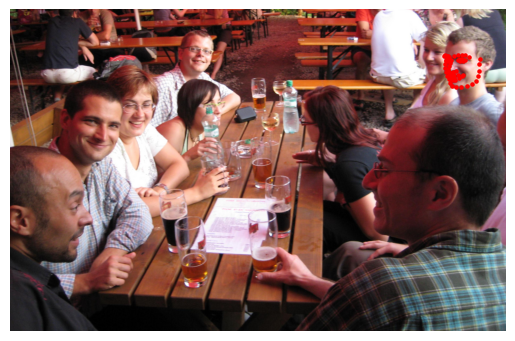

In [126]:
visualize_face_with_original_landmarks(img_name, landmarks)

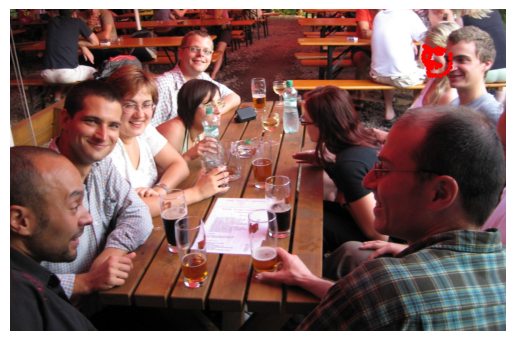

In [127]:
gt_landmarks = load_landmarks(gt_landmark_name)
visualize_face_with_original_landmarks(img_name, gt_landmarks)

In [109]:
landmarks = inference_on_image_dlib(img_name, load_landmarks(gt_landmark_name))

In [85]:
def count_ced(predicted_landmarks, gt_landmarks):
    ceds = []
    for i in range(len(predicted_landmarks)):
        if predicted_landmarks[i] is not None:
            x_pred, y_pred = predicted_landmarks[i][:, 0], predicted_landmarks[i][:, 1]
            x_gt, y_gt = gt_landmarks[i][:, 0], gt_landmarks[i][:, 1]
            if len(x_gt) == 68:
                w = np.max(x_gt) - np.min(x_gt)
                h = np.max(y_gt) - np.min(y_gt)
                normalization_factor = np.sqrt(h * w)
                
                diff_x = x_gt - x_pred
                diff_y = y_gt - y_pred
                dist = np.sqrt(np.square(diff_x) + np.square(diff_y))
                avg_norm_dist = np.sum(dist) / (len(x_gt) * normalization_factor)
                ceds.append(avg_norm_dist)
    return ceds

def count_ced_auc(errors):
  if not isinstance(errors, list):
    errors = [errors]

  aucs = []
  for error in errors:
    auc = 0
    proportions = np.arange(error.shape[0], dtype=np.float32) / error.shape[0]
    assert (len(proportions) > 0)

    step = 0.01
    for thr in np.arange(0.0, 1.0, step):
      gt_indexes = [idx for idx, e in enumerate(error) if e >= thr]
      if len(gt_indexes) > 0:
        first_gt_idx = gt_indexes[0]
      else:
        first_gt_idx = len(error) - 1
      auc += proportions[first_gt_idx] * step
    aucs.append(auc)
  return aucs

In [128]:
root_dir = './landmarks_task/300W/test/'
image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
landmarks_files = [f for f in os.listdir(root_dir) if f.endswith('.pts')]
pred_landmarks_torch = []
pred_landmarks_dlib = []
gt_landmarks = []
for i in tqdm(range(len(image_files))):
    img_name = os.path.join(root_dir, image_files[i])
    gt_landmark_name = os.path.join(root_dir, landmarks_files[i])
    try:
        pred_landmarks_torch.append(inference_on_image(img_name, model, load_landmarks(gt_landmark_name)))
        pred_landmarks_dlib.append(inference_on_image_dlib(img_name, load_landmarks(gt_landmark_name)))
        gt_landmarks.append(load_landmarks(gt_landmark_name))
    except:
        pass

  0%|          | 0/281 [00:00<?, ?it/s]

In [129]:
ced_array_torch = count_ced(pred_landmarks_torch, gt_landmarks)
ced_array_dlib = count_ced(pred_landmarks_dlib, gt_landmarks)

In [130]:
def calculate_auc(errors, threshold):
    sorted_errors = np.sort(errors)
    cumulative_percentage = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    auc = np.trapz(cumulative_percentage[sorted_errors <= threshold], sorted_errors[sorted_errors <= threshold])
    return auc

def plot_ced(errors, threshold):
    sorted_errors = np.sort(errors)
    cumulative_percentage = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
    auc = calculate_auc(errors, threshold)
    
    plt.plot(sorted_errors, cumulative_percentage, marker='o', linestyle='-', label=f'AUC up to {threshold:.2f}: {auc:.4f}')
    plt.xlabel('Normalized Mean Squared Error')
    plt.ylabel('Cumulative Percentage of Images (%)')
    plt.title('Cumulative Error Distribution (CED), 300W test split')
    plt.grid(True)
    plt.xlim(0, threshold)
    plt.legend()
    plt.show()

def plot_ced_2_predictors(errors_1, errors_2, threshold, name_1='Errors 1', name_2='Errors 2'):
    sorted_errors_1 = np.sort(errors_1)
    sorted_errors_2 = np.sort(errors_2)
    
    cumulative_percentage_1 = np.arange(1, len(sorted_errors_1) + 1) / len(sorted_errors_1) * 100
    cumulative_percentage_2 = np.arange(1, len(sorted_errors_2) + 1) / len(sorted_errors_2) * 100
    
    auc_1 = calculate_auc(errors_1, threshold)
    auc_2 = calculate_auc(errors_2, threshold)
    
    plt.plot(sorted_errors_1, cumulative_percentage_1, marker='o', linestyle='-', label=f'{name_1} - AUC up to {threshold:.2f}: {auc_1:.4f}')
    plt.plot(sorted_errors_2, cumulative_percentage_2, marker='o', linestyle='-', label=f'{name_2} - AUC up to {threshold:.2f}: {auc_2:.4f}')
    
    plt.xlabel('Normalized Mean Squared Error')
    plt.ylabel('Cumulative Percentage of Images (%)')
    plt.title('Cumulative Error Distribution (CED), Menpo test split')
    plt.grid(True)
    plt.xlim(0, threshold)
    plt.legend()
    plt.show()

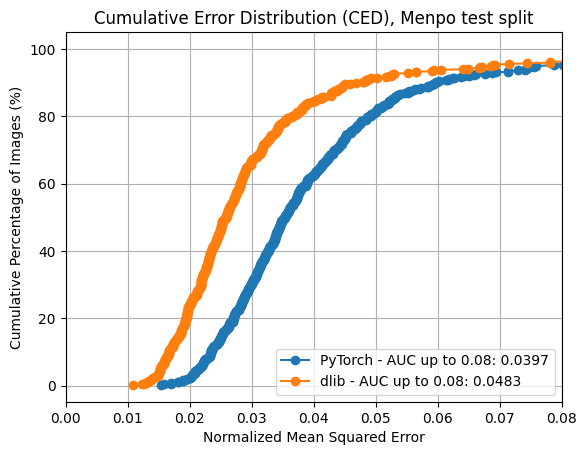

In [119]:
plot_ced_2_predictors(ced_array_torch, ced_array_dlib, threshold=0.08, name_1='PyTorch', name_2='dlib')

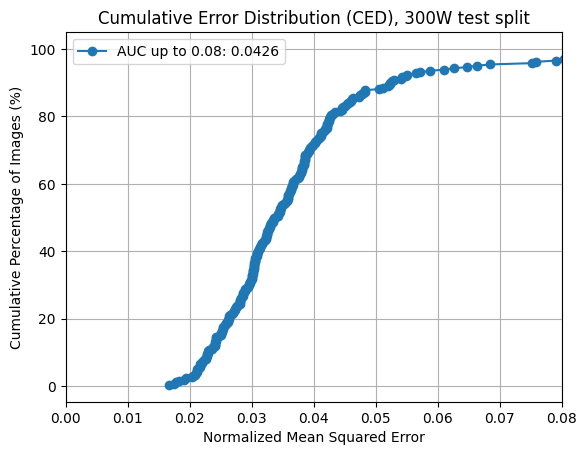

In [131]:
threshold = 0.08
plot_ced(ced_array, threshold)